# Zastosowania DFT

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageOps
from skimage import measure
import numpy as np

## Funkcje pomocnicze

Poniżej zaimplementowano obliczanie korelacji pomiędzy wzorcem, a całym obrazem przy pomocy transformacji Fouriera oraz filtrowanie fragmentów obrazu, gdzie ta korelacja jest największa. Zgodnie z twierdzeniem o konwolucji, operacja konwolucji w dziedzinie wyjściowej jest mnożeniem w dziedzinie częstotliwości. Aby z konwolucji otrzymać korelację musimy obrócić macierz wzorca o $180^\circ$. Skorzystano z funkcji dostępnych w bibliotece numpy.

In [2]:
def correlation(image, pattern):
    pattern_rotated = np.rot90(pattern, 2)
    frequencies_pattern = np.fft.fft2(pattern_rotated, image.shape)     
    frequencies_image = np.fft.fft2(image)
    return np.real(np.fft.ifft2(np.multiply(frequencies_pattern, frequencies_image)))

def filter_picks(image, sensitivity=0.9):
    image_filtered = np.copy(image)
    image_filtered[image<np.max(image)*sensitivity] = 0.
    return image_filtered

Kolejne dwie funkcje slużą do wyświetlania danych.

In [3]:
def show_image(image, lower_contrast=False, title='', scale=60, cmap='gray'):
    if lower_contrast:
        image = np.log(image)

    image = 255.*image/np.max(image)
    height, width = image.shape
    fig, ax = plt.subplots(figsize=(height//scale, width//scale))
    ax.set_title(title)
    ax.imshow(image, cmap=cmap, interpolation='none')
    plt.show()
    
def show_filtered_objects(path, correlation, sensitivity=0.9, scale=70, title='', squares=True):
    image = Image.open(path)
    if squares:
        image = image.convert('L')
    image_arr = np.array(image)
    
    height, width = correlation.shape
    fig, ax = plt.subplots(figsize=(height//scale, width//scale))
    ax.set_title(title)
        
    image_filtered = filter_picks(correlation, sensitivity)

    if squares:
        objects_found = 0
        ax.imshow(image, cmap='gray', interpolation='none')
        for i in range(height):
            for j in range(width):
                if image_filtered[i][j]!=0.:
                    square = patches.Rectangle((j,i), -13, -13, linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(square)
                    letters_found+=1
    else:
        ax.imshow(image, interpolation='none')
        objects_found = len(measure.find_contours(image_filtered, sensitivity*np.max(image_filtered)))
        image_filtered[image_filtered==0] = np.nan
        ax.imshow(image_filtered, interpolation='none', cmap='Reds')
        
    plt.show()
    return objects_found


## Wczytanie danych

Wczytano przygotowane obrazy i zrzutowano je do formatu jednokanałowego przy pomocy biblioteki PIL. Dla danych tekstowych dodatkowo odwrócono kolory, aby piksele odpowiadające za litery były sygnałem o wyższej wartości.

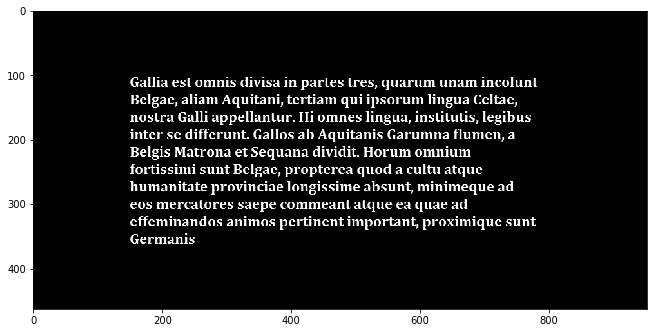

In [4]:
letters = ImageOps.invert(Image.open("galia.png").convert('L'))
letters_arr = np.array(letters)
show_image(letters_arr, scale=40)

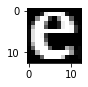

In [5]:
letter_e = ImageOps.invert(Image.open("galia_e.png").convert('L'))
letter_e_arr = np.array(letter_e)
show_image(letter_e_arr, scale=10)

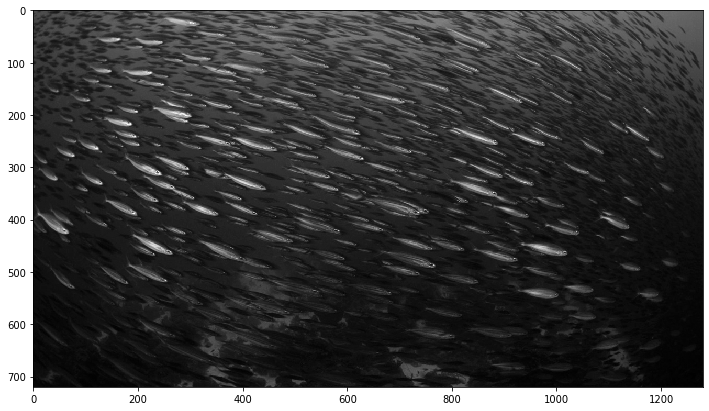

In [6]:
school = Image.open("school.jpg").convert('L')
school_arr = np.array(school)
show_image(school_arr)

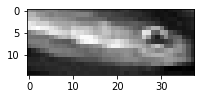

In [7]:
fish = Image.open("fish1.png").convert('L')
fish_arr = np.array(fish)
show_image(fish_arr, scale=5)

## Transformacja do domeny częstotliwości

Poniżej przedstwiono transformację obrazów do domeny częstotliwości. Dodatkowo przesunięto wynikowe obrazy tak, żeby komponent zerowej częstotliwość znalazł się na jego środku. 

In [8]:
frequencies_letters = np.fft.fftshift(np.fft.fft2(letters_arr))
frequencies_school = np.fft.fftshift(np.fft.fft2(school_arr))

Na poniższych dwóch wykresach zaprezentowano moduł otrzymanych po transformacji wyników. Ponieważ otrzymany po transformacji obraz ma w sobie kilka pików o dużych wartościach, dla lepszej wizualizacji (aby mniejsze różnice wartości były bardziej widoczne) zlogarytmowano wartości w obrazie.

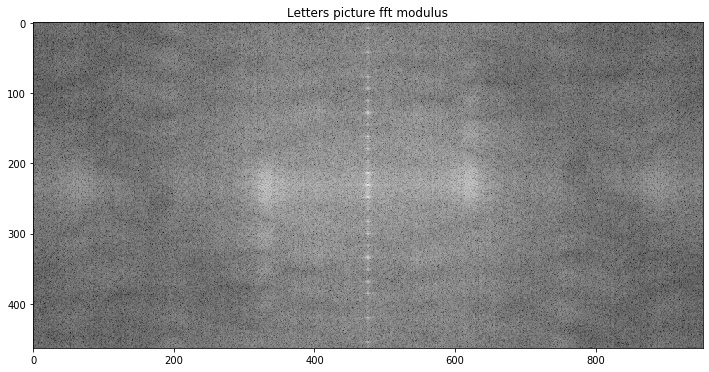

In [9]:
modulus_letters = np.absolute(frequencies_letters)
show_image(modulus_letters, lower_contrast=True, scale=38, title='Letters picture fft modulus')

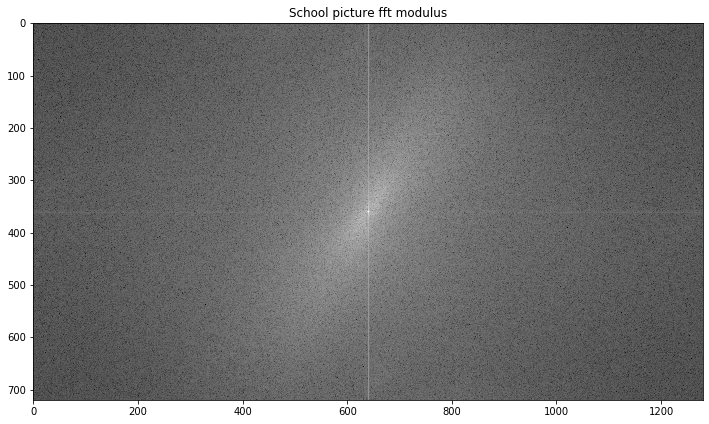

In [10]:
modulus_school = np.absolute(frequencies_school)
show_image(modulus_school, lower_contrast=True, title='School picture fft modulus')

Można zauważyć, że wyższe wartości modułów układają się prostopadle do osi kompozycyjnej obrazów. Sygnał w tekście jest ułożony horyzontalnie, a otrzymane wyższe wartości modułu wertykalnie. Tak samo sygnał o wysokiej wartości pochodzący od jasnych łusek ryb wyznacza kierunek diagonalny, stąd prostopadły do niego, skoncentrowany głównie wokół środka wzrost wartości modułów na obrazie po transformacji.

Dla danych tekstowych może to być szczególnie przydatna cecha, gdyż można na jej podstawie wnioskować, czy tekst jest przechylony i jeśli jest, to o jaki kąt.

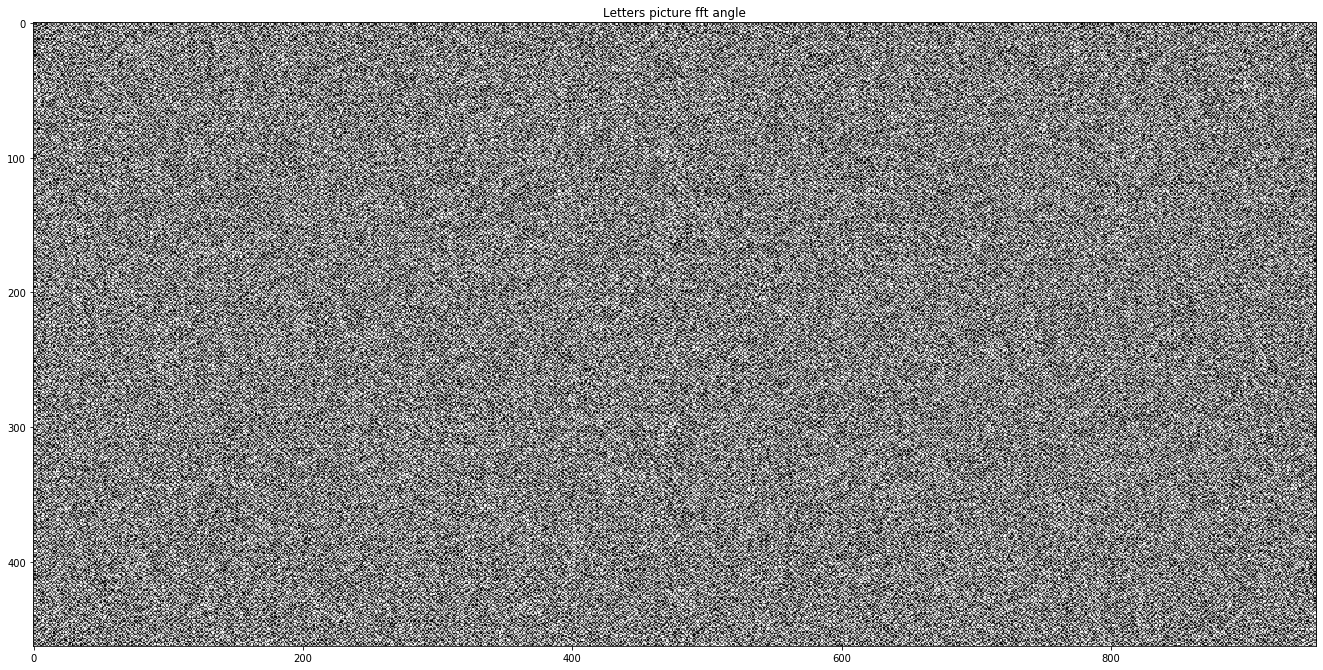

In [11]:
angle_letters = np.angle(frequencies_letters)
show_image(angle_letters, scale=20, title='Letters picture fft angle')

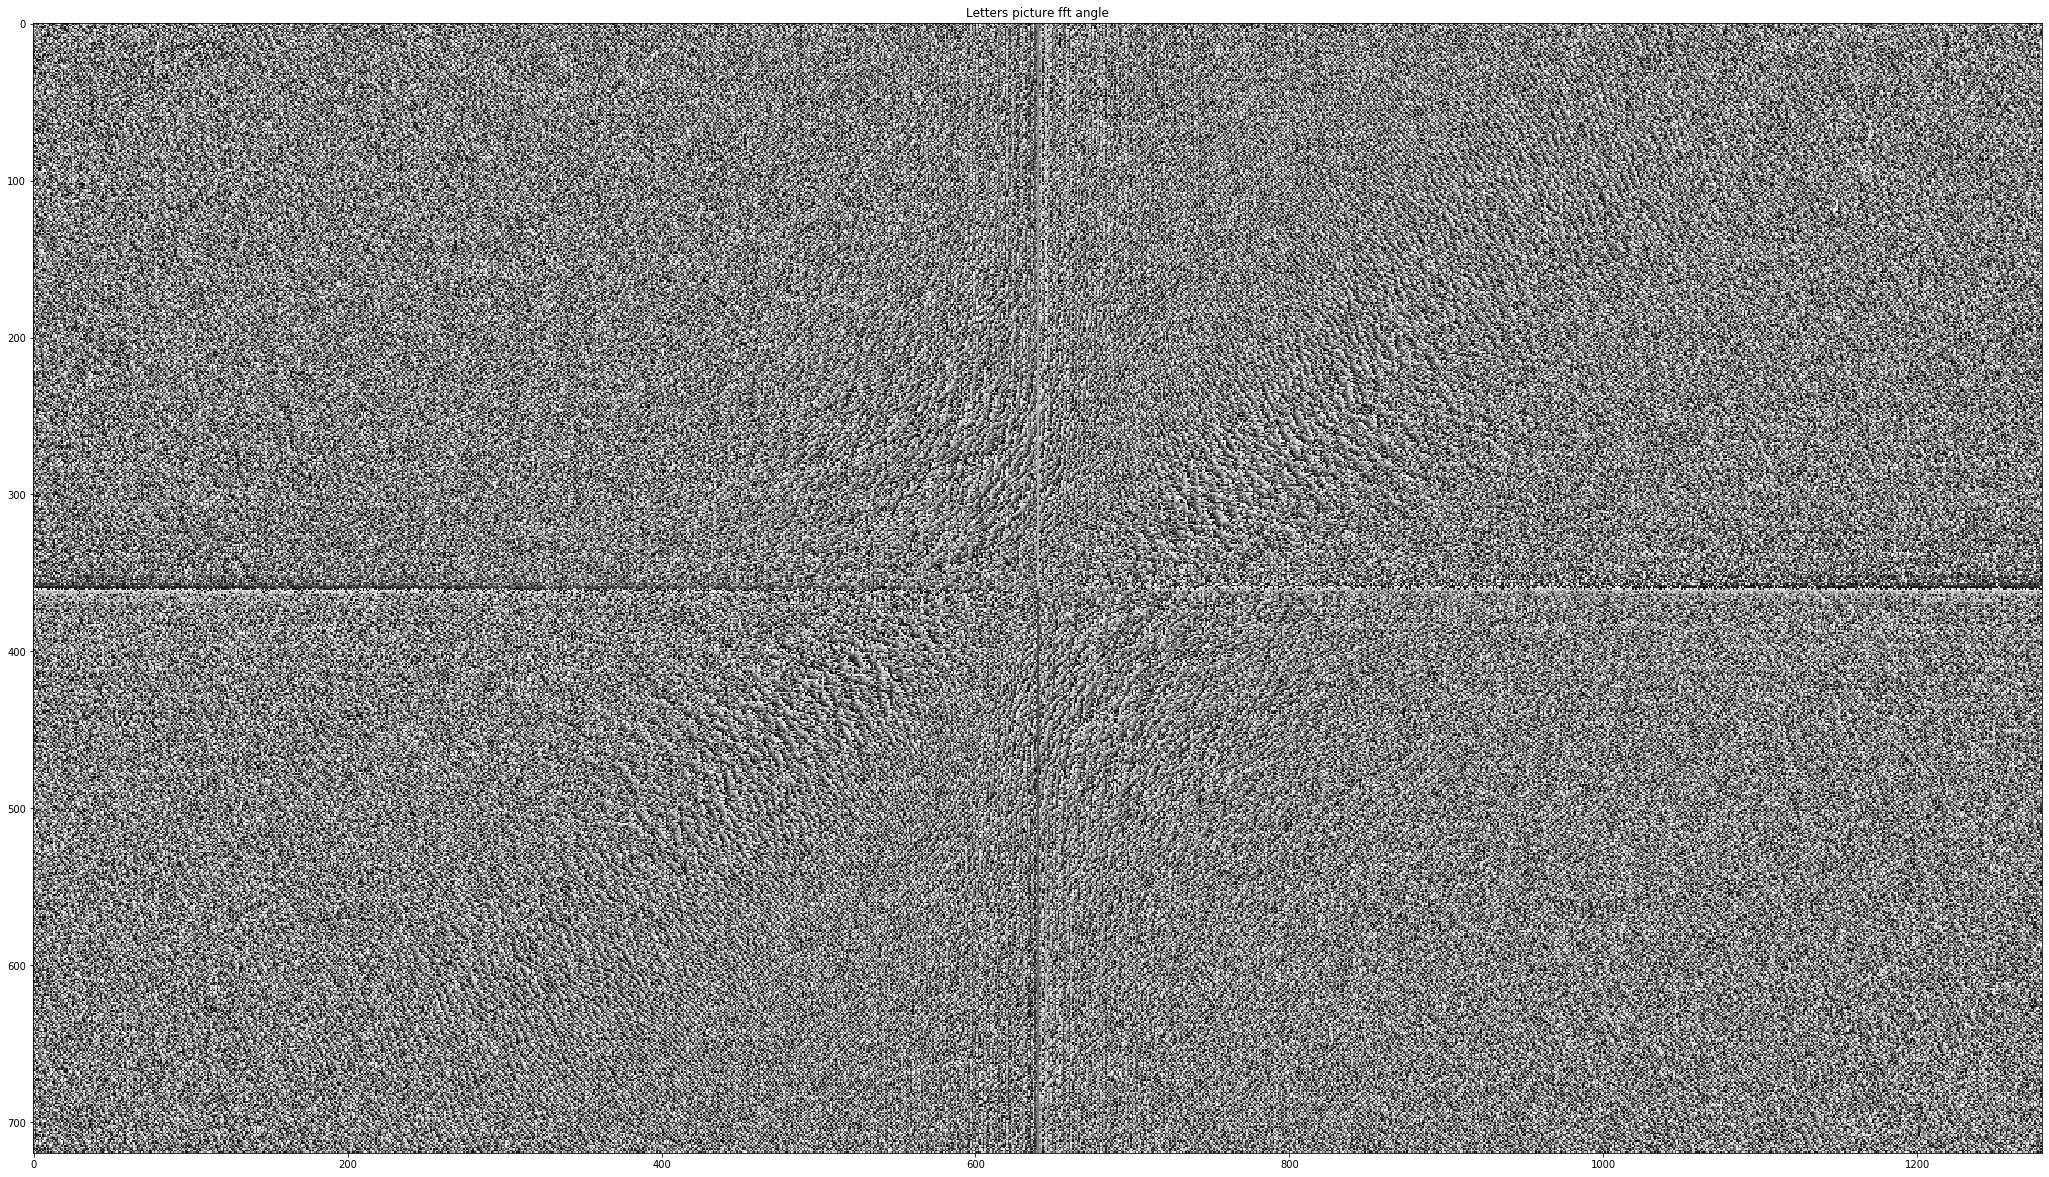

In [12]:
angle_school = np.angle(frequencies_school)
show_image(angle_school, scale=20, title='Letters picture fft angle')

Wartość fazy transformaty Fouriera pozwalają w transformacji odwrotnej zrekonstruwać kontur. Dla danych periodycznych, takich jak tekst wizualizacja fazy przedstawia jedynie delikatne prostokątne struktury na całym obrazie. Dla ławicy ryb widać zarysowane osie centralne oraz diagonalną regularność w centrum. Aby lepiej zwizualizować zalezność fazy od konturu, wybrałam obraz z wyraźniejszymi krawędzimi i mniejszą regularnością. Transformowałam go do dziedziny częstotliwości, a następnie zrekonstruowałam obraz transformacją odwrotną, przyjmując na wejściu dane zależne jedynie od fazy o module równym $1$. Udało się zrekonstruować kontur.

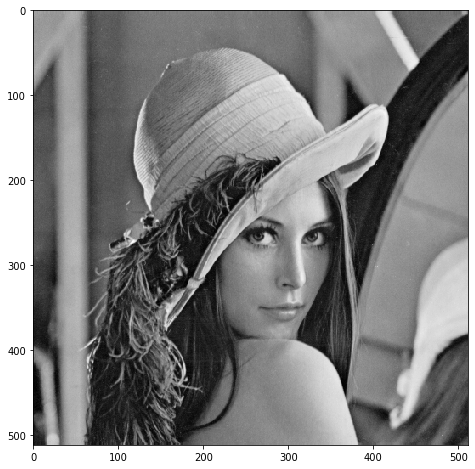

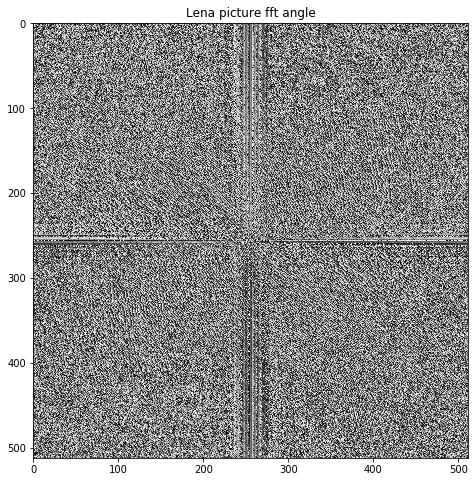

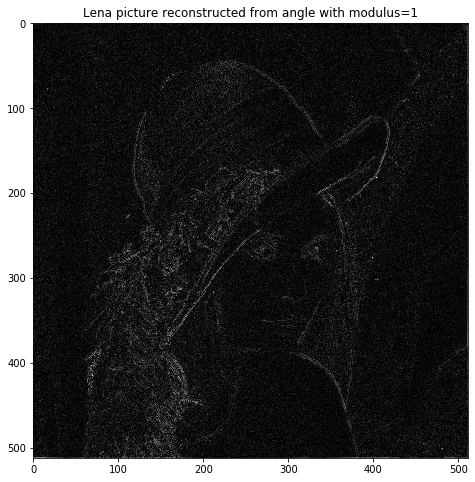

In [23]:
lena = Image.open("lena.png").convert('L')
lena_arr = np.array(lena)
show_image(lena_arr)
frequencies_lena = np.fft.fftshift(np.fft.fft2(lena_arr))
modulus_lena = np.absolute(frequencies_lena)
angle_lena = np.angle(frequencies_lena)
show_image(angle_lena, title='Lena picture fft angle')
show_image(np.absolute(np.fft.ifft2(frequencies_lena/modulus_lena)), title='Lena picture reconstructed from angle with modulus=1')

## Korelacja między wzorcem i obrazem


### Wyszukiwanie litery e w tekście

Poniżej przedstawiono wartości korelacji dla obrazu tekstu i litery e, odcięte piki oraz znalezione lokalizacje litery e. Znaleziono jej wszystkie wystąpienia.

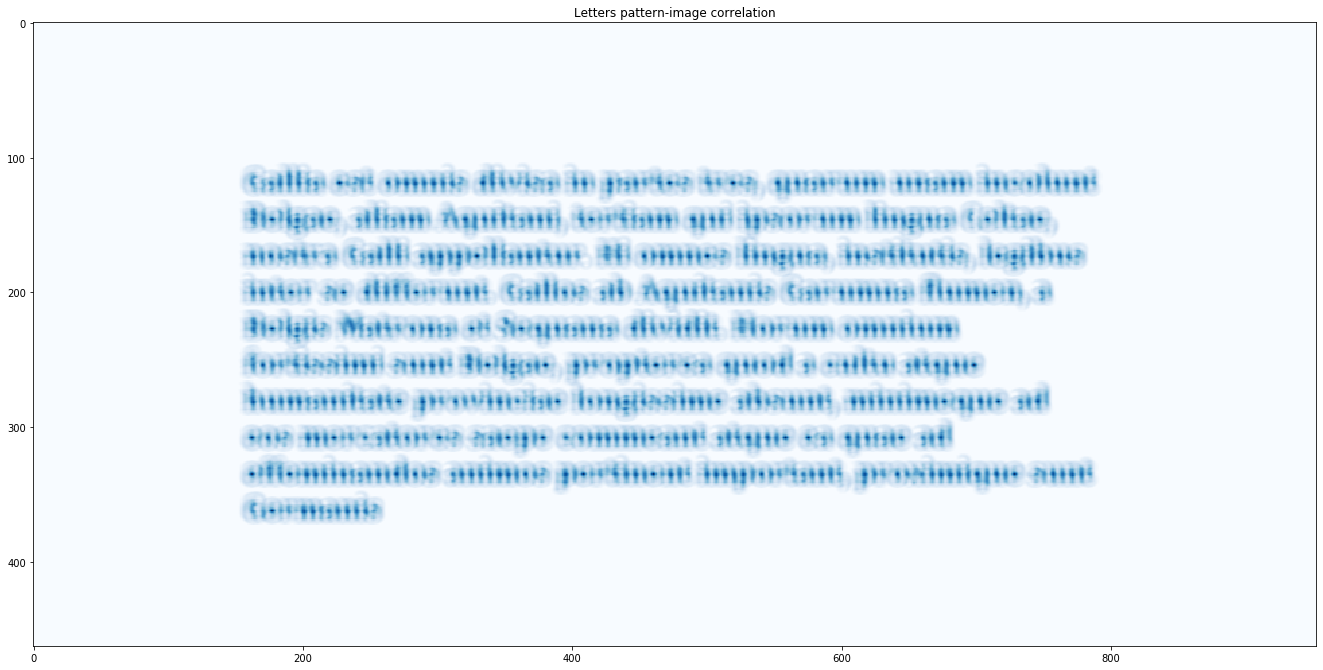

In [47]:
correlation_letters = correlation(letters_arr, letter_e_arr)
show_image(correlation_letters, title='Letters pattern-image correlation', scale=20, cmap='Blues')

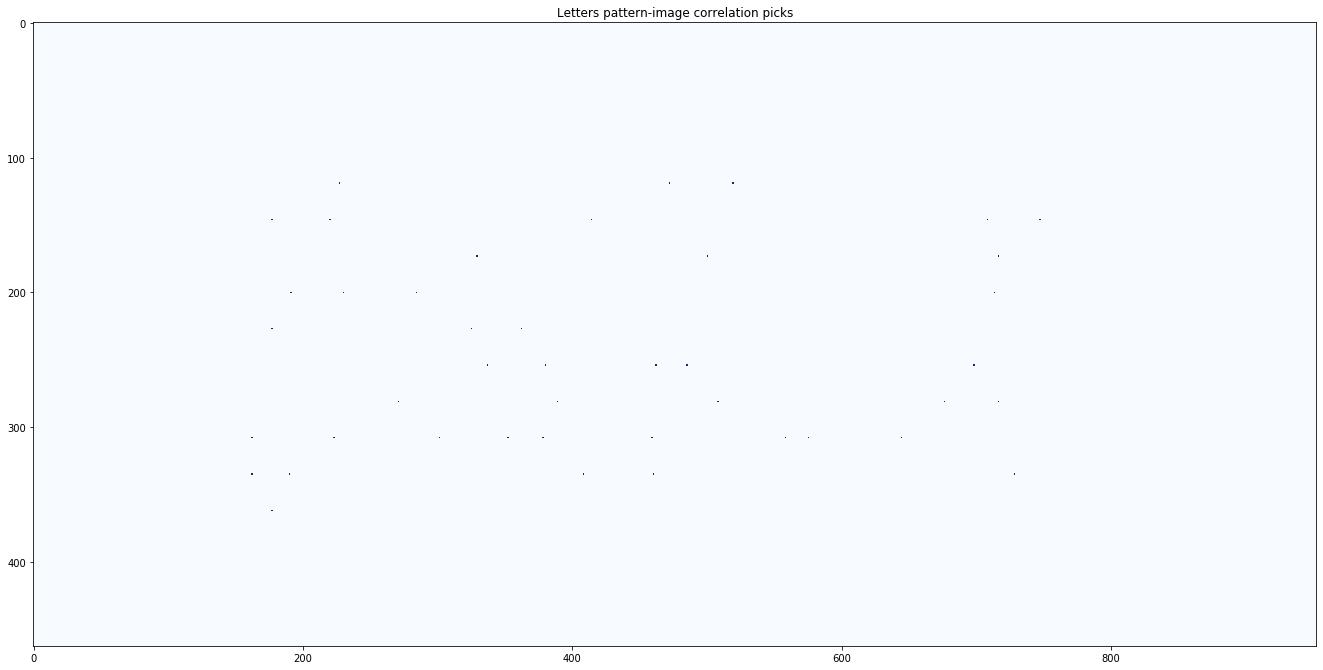

In [76]:
correlation_filtered_letters = filter_picks(correlation_letters, sensitivity=0.9)
show_image(correlation_filtered_letters, title='Letters pattern-image correlation picks', scale=20, cmap='Blues')

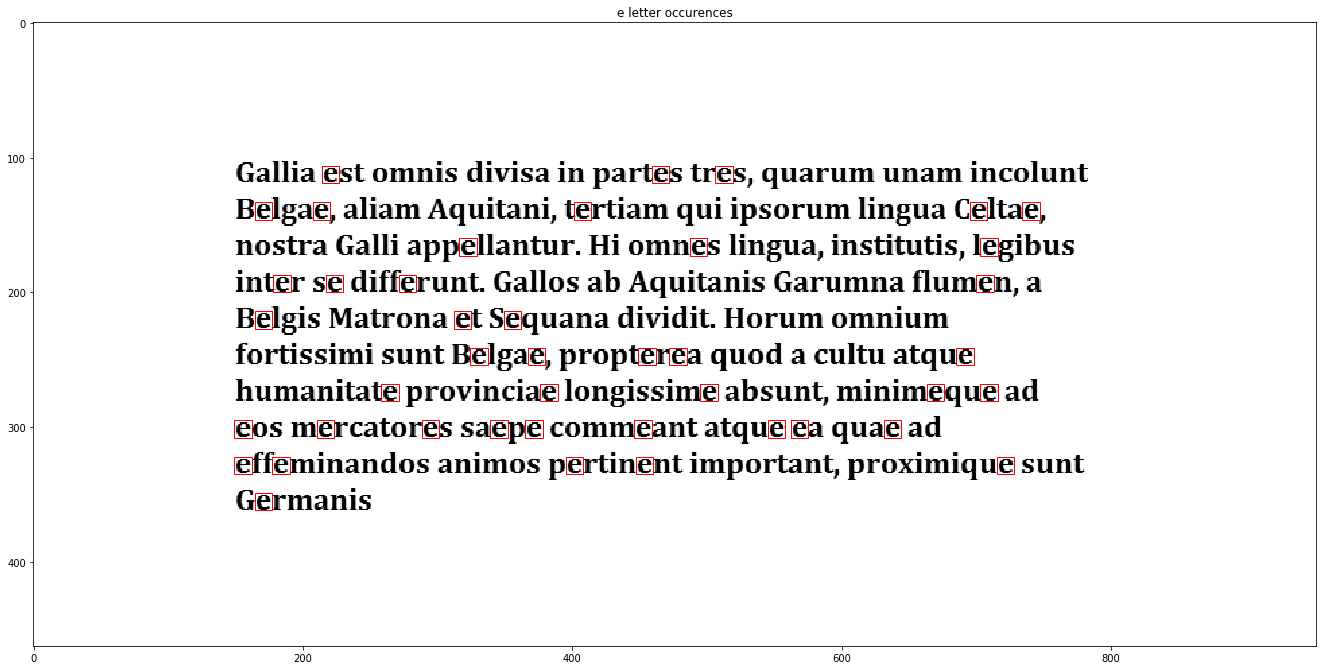

e letter occured 43 times


In [77]:
e_occurences = show_filtered_objects('galia.png', correlation_letters, sensitivity=0.9, scale=20, title='e letter occurences')
print(f'e letter occured {e_occurences} times')

### Wyszukiwanie ryb w ławicy

Analogicznie postąpiono ze zdjęciem ławicy ryb. Aby policzyć liczbę wystąpień ryb na obrazie, policzono liczbę spójnych składowych obrazu przy pomocy biblioteki PIL. Tym razem metoda okazała się mniej precyzyjna.Jest to spowodowane tym, że nie dysponujemy tak dokładnym wzorcem jak w przypadku pojedyńczej litery.

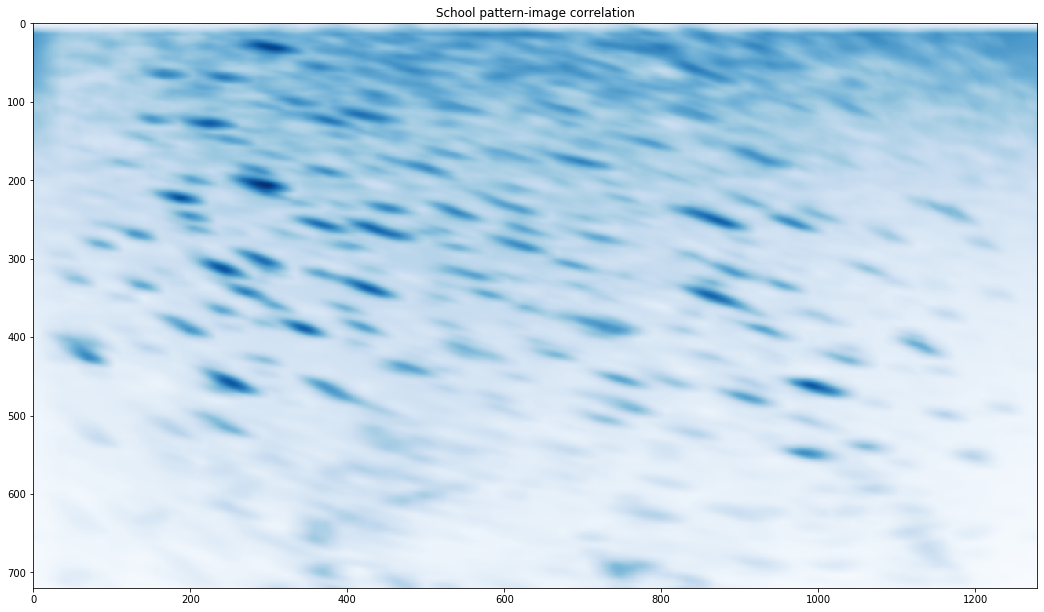

In [78]:
correlation_school = correlation(school_arr, fish_arr)
show_image(correlation_school, title='School pattern-image correlation', scale=40, cmap='Blues')

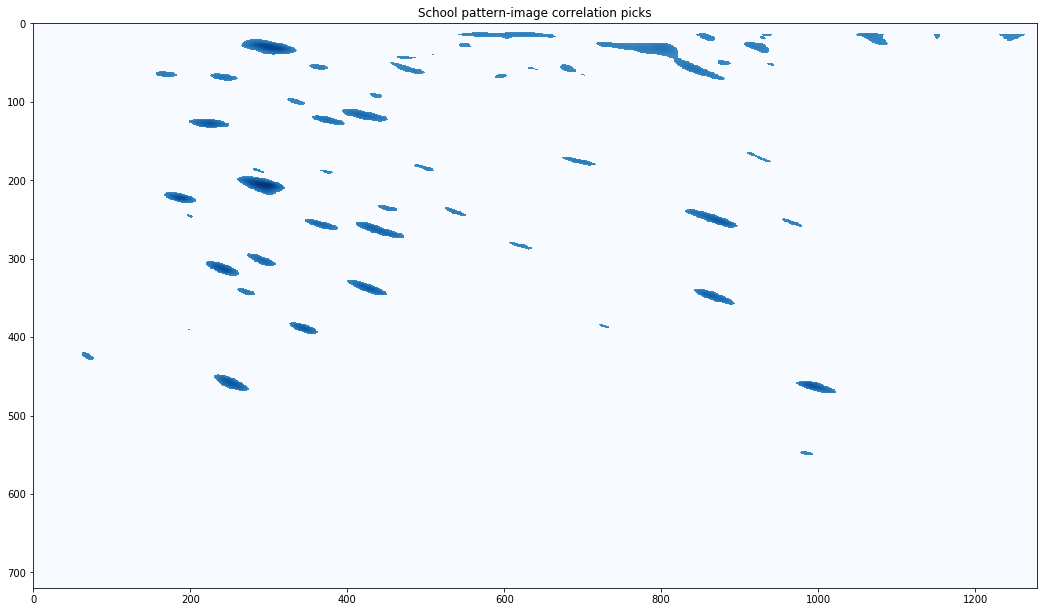

In [81]:
correlation_filtered_school = filter_picks(correlation_school, sensitivity=0.65)
show_image(correlation_filtered_school, title='School pattern-image correlation picks', scale=40, cmap='Blues')

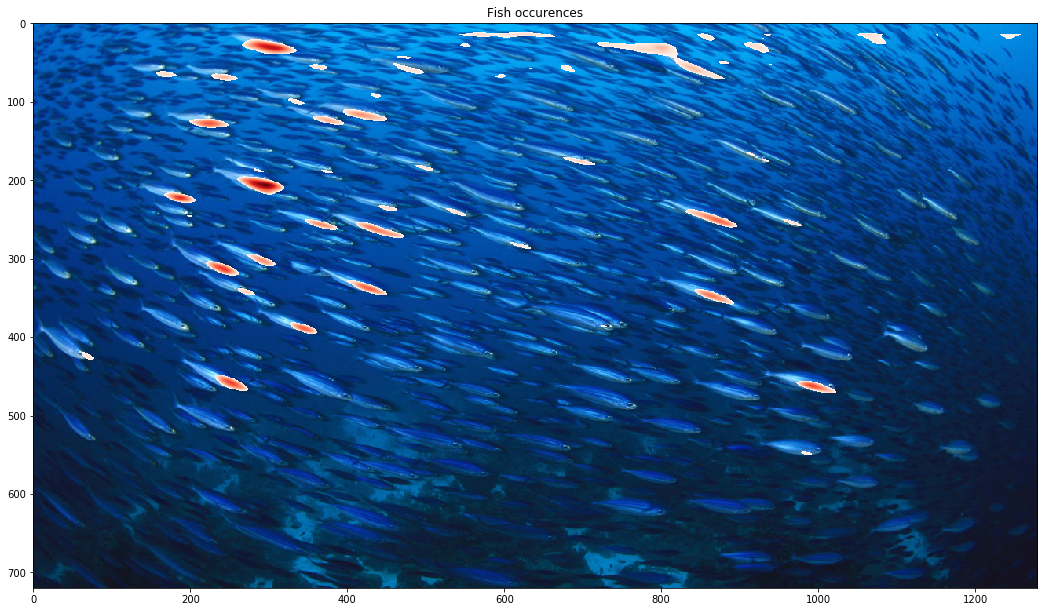

Fish pattern occured 54 times


In [98]:
fish_occurences = show_filtered_objects('school.jpg', correlation_school, sensitivity=0.655, 
                                        scale=40, title='Fish occurences', squares=False)
print(f'Fish pattern occured {fish_occurences} times')

### Wnioski

Transformacja Fouriera pozwala nam na wydajniejsze wyliczenie korelacji wzorca i obrazu, gdyż wymnożenie dwóch macierzy element po elemecie wymaga mniejszej liczby operacji mnożenia niż wykonanie operacji korelacji na macierzy obrazu i macierzy wzorca.

Tranformacja Fouriera pozwala nam na wydobycie z obrazu takich informacji jak orientacja tekstu, położenia poszukiwanego wzorca oraz periodyczność obrazu.